<a href="https://colab.research.google.com/github/CardosoJr/bootcamp/blob/main/Labs/Lab_16_Intro_to_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 16 - Introdução as Redes Neurais Convolucionais

## O que é uma CNN? 


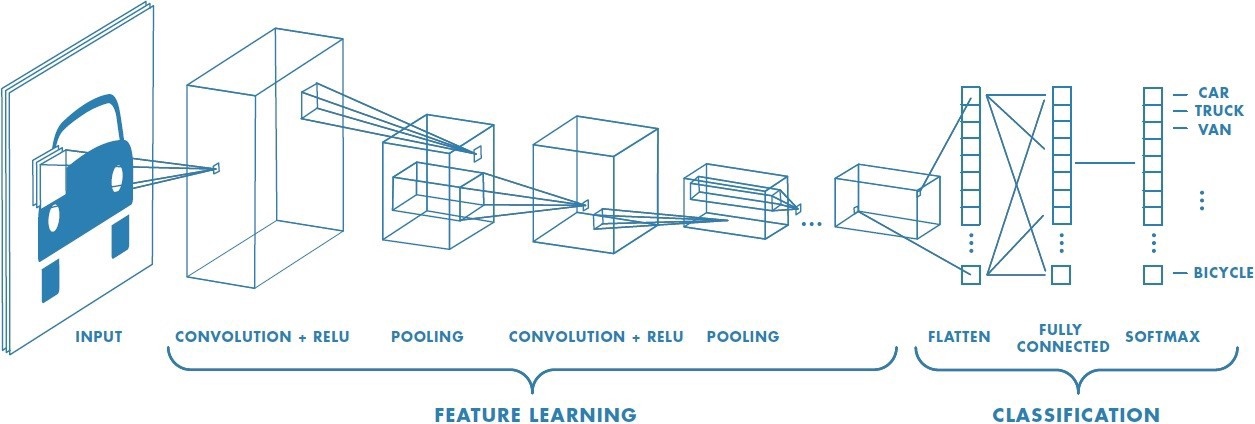

## Leitura dos Dados

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

# Importando libs de plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, precision_recall_curve, auc, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

data_transform = transforms.ToTensor()

train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train data, number of images:  60000
Test data, number of images:  10000


### Os dados

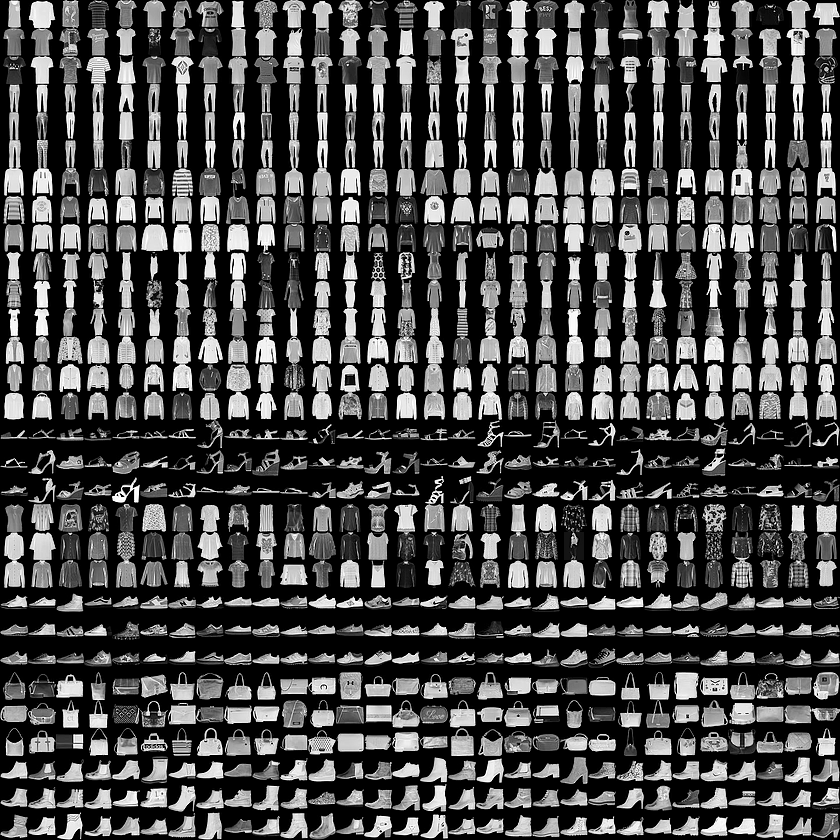

### Visualizando algumas amostras

In [4]:
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

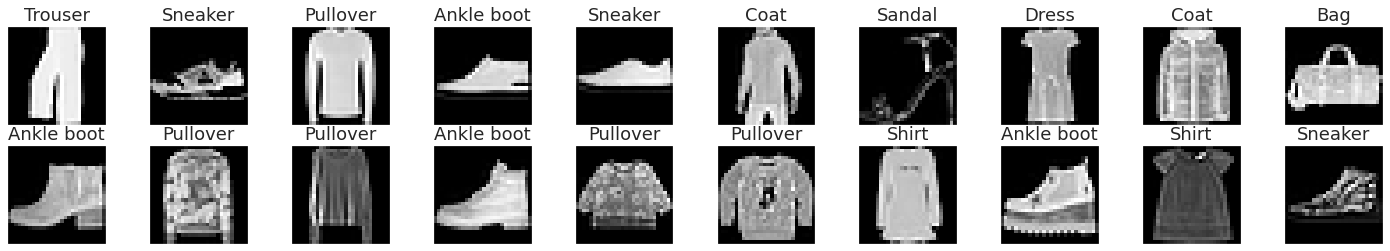

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

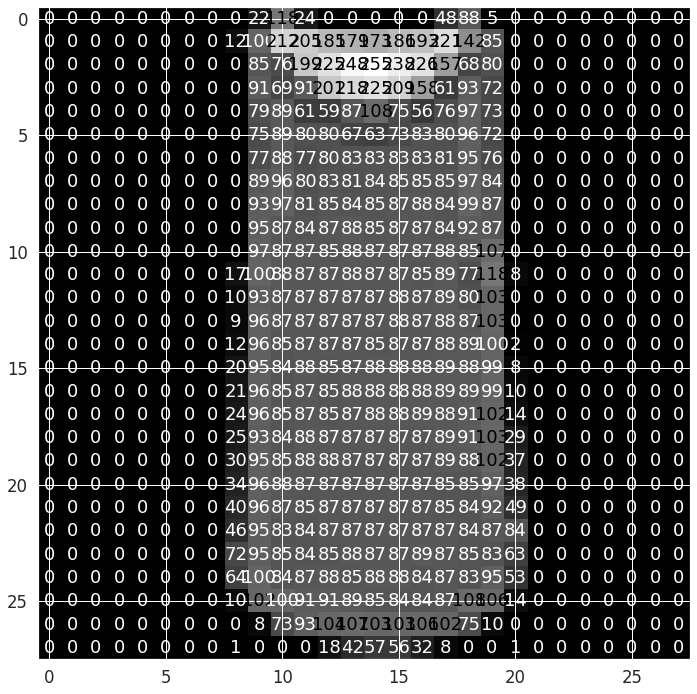

In [113]:
# select an image by index
idx = 2
img = np.squeeze(train_data.data.numpy()[idx])

# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Resolvendo com um Xgboost

In [25]:
np_train = train_data.data.numpy()
np_train_y = train_data.targets.numpy()
np_test = test_data.data.numpy()
np_test_y = test_data.targets.numpy()

In [26]:
np_train.shape

(60000, 28, 28)

In [27]:
np_train = np_train.reshape(60000, 28*28)
np_test = np_test.reshape(10000, 28*28)

In [43]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(objective = "multi:softmax", num_class = 10, n_estimators = 200, n_jobs=-1, seed=0)
xgb_clf.fit(np_train,np_train_y)

XGBClassifier(n_estimators=200, n_jobs=-1, num_class=10,
              objective='multi:softprob', seed=0)

In [53]:
y_pred = xgb_clf.predict(np_test)
print(accuracy_score(np_test_y, y_pred))

0.8386


## CNNs 

### Operação de Convolução

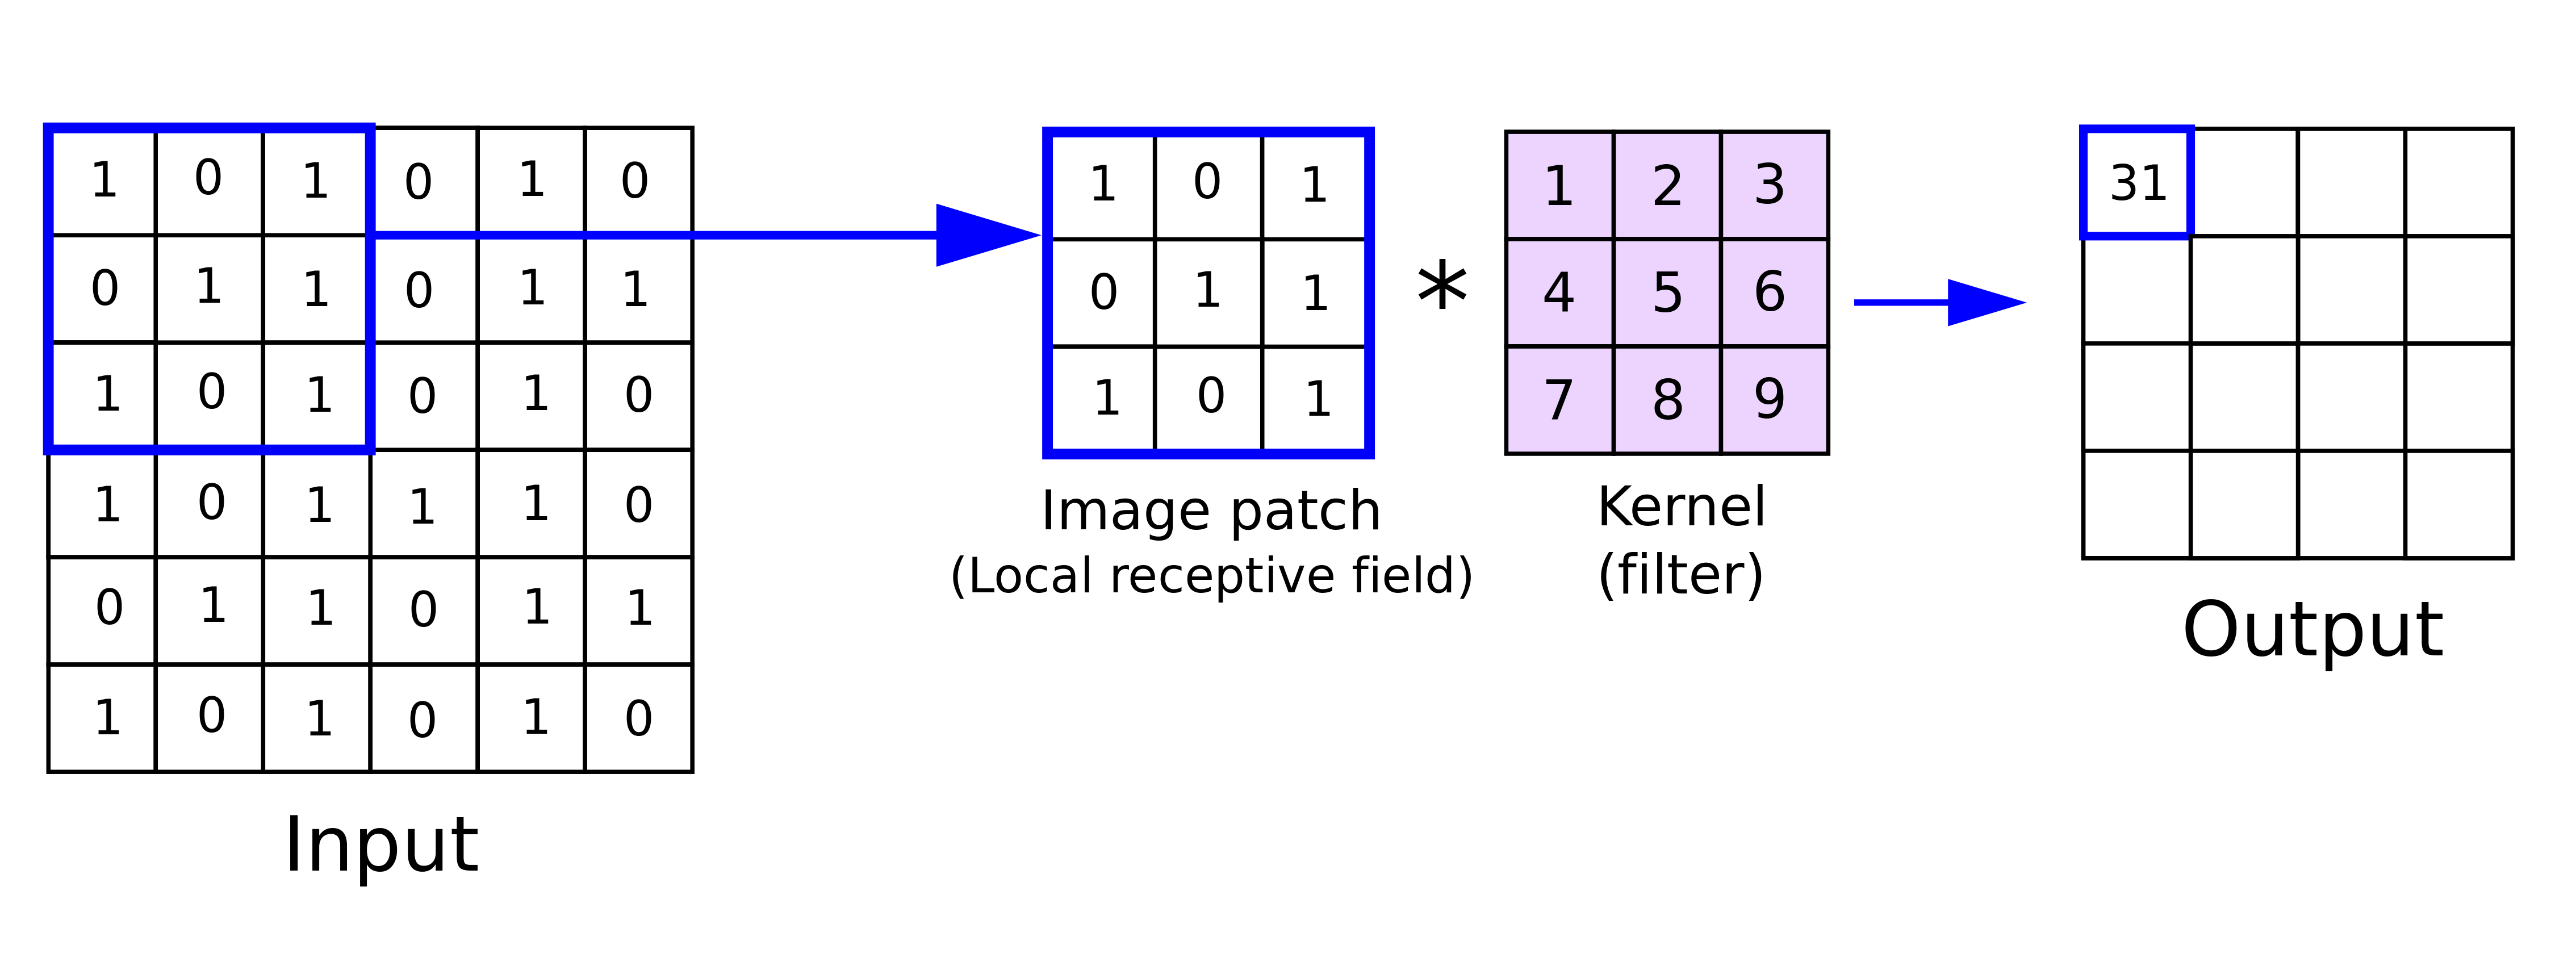

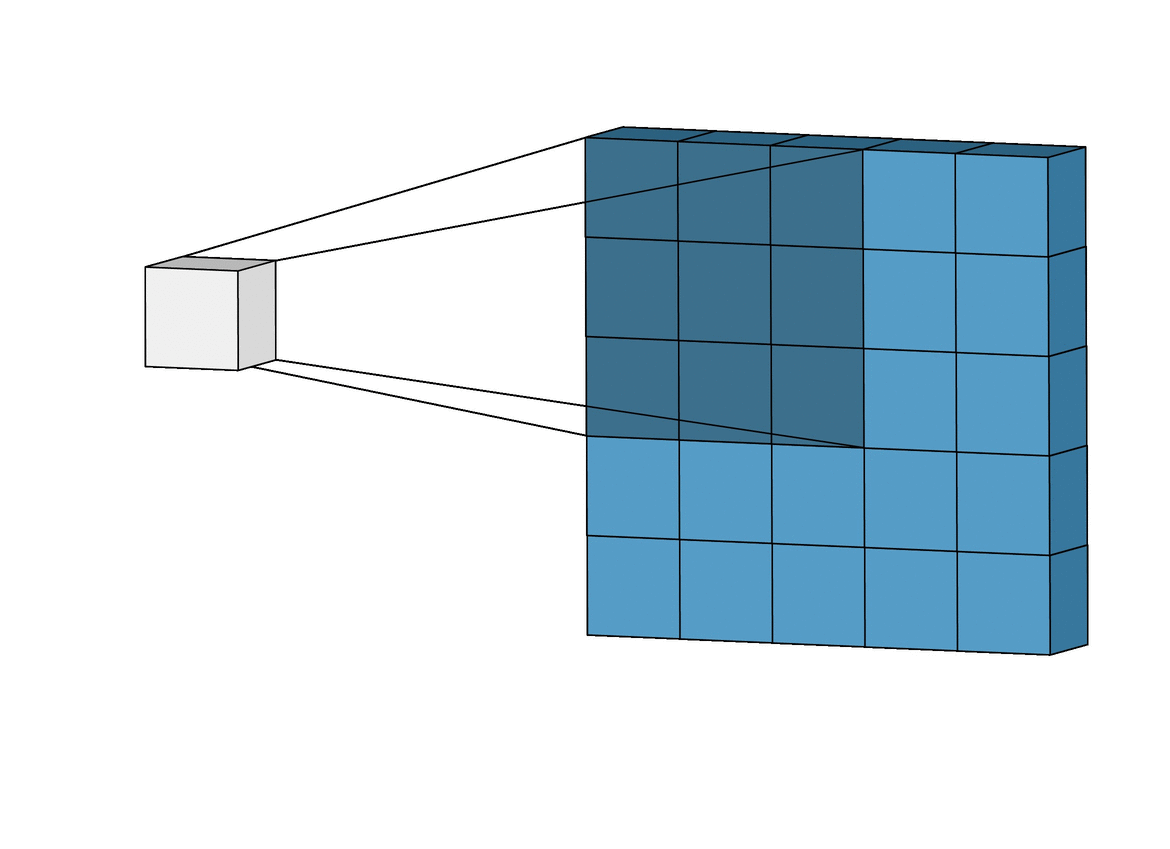

### Operação de Maxpooling

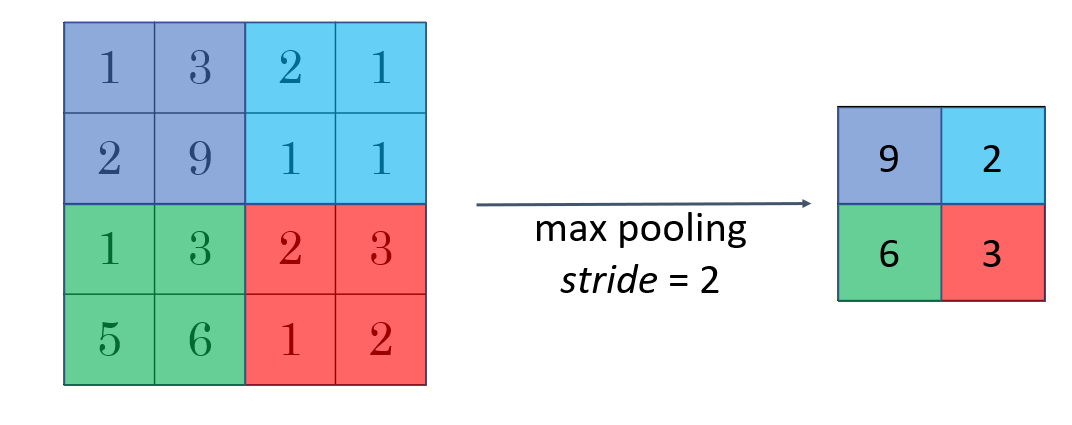

### Construindo uma CNN em Pytorch

In [45]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Como calcular o shape da saída ((W - K + 2P)/S) + 1
        # W - tamanho original
        # K - tamanho do kernel
        # P - padding
        # S - stride

        # ENTRADA: 28 x 28 x 1
        
        ## Define a convolutional layer
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        filters_1 = 10
        self.conv1 = nn.Conv2d(1, filters_1, 3)   # SAIDA 26 x 26 x 10
        
        # a pooling layer that reduces the size of the image by 2
        self.pool1 = nn.MaxPool2d(2,2) # 13 x 13 x 10
        
        filters_2 = 20
        self.conv2 = nn.Conv2d(filters_1, filters_2, 3) # 10 x 10 x 20

        self.pool2 = nn.MaxPool2d(2,2) # 5 x 5 x 20
        
        n_classes = 10
        self.fc1 = nn.Linear(filters_2*5*5, n_classes)
        

    ## Define the forward behavior
    def forward(self, x):
        # both conv/pool layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # flatten the output of the final pooling layer
        # pass it as input to the fully-connected layer
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        # final output
        return x

# create and print your Net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500, out_features=10, bias=True)
)


In [46]:
import torch.optim as optim

## Specify loss function (try categorical cross-entropy)
loss_function = nn.CrossEntropyLoss()

## Specify optimizer (I'm using stochastic gradient descent)
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [47]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = net(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
accuracy = 100 * correct / total

# print it out!
print('Accuracy before training: ', accuracy.item())

Accuracy before training:  10.15999984741211


#### Treinando a Rede

In [48]:
def train(n_epochs):
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data       

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = net(inputs)

            # calculate the loss
            loss = loss_function(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            if batch_i % 1000 == 999:    # print every 1000 mini-batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [49]:
n_epochs = 15

# call train
train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.1503338469564914
Epoch: 1, Batch: 2000, Avg. Loss: 0.7110702356696129
Epoch: 1, Batch: 3000, Avg. Loss: 0.6090077021569014
Epoch: 2, Batch: 1000, Avg. Loss: 0.5575449057221412
Epoch: 2, Batch: 2000, Avg. Loss: 0.5152438377030194
Epoch: 2, Batch: 3000, Avg. Loss: 0.5195865895822644
Epoch: 3, Batch: 1000, Avg. Loss: 0.4851158695630729
Epoch: 3, Batch: 2000, Avg. Loss: 0.4859130996242166
Epoch: 3, Batch: 3000, Avg. Loss: 0.4531836721803993
Epoch: 4, Batch: 1000, Avg. Loss: 0.4569379140213132
Epoch: 4, Batch: 2000, Avg. Loss: 0.4322671154141426
Epoch: 4, Batch: 3000, Avg. Loss: 0.43309125703200696
Epoch: 5, Batch: 1000, Avg. Loss: 0.4291258874088526
Epoch: 5, Batch: 2000, Avg. Loss: 0.4174734303057194
Epoch: 5, Batch: 3000, Avg. Loss: 0.4066835267096758
Epoch: 6, Batch: 1000, Avg. Loss: 0.4084573708772659
Epoch: 6, Batch: 2000, Avg. Loss: 0.4020817782729864
Epoch: 6, Batch: 3000, Avg. Loss: 0.38731470439210536
Epoch: 7, Batch: 1000, Avg. Loss: 0.38240292

#### Testando no Conjunto de Treino

In [50]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)

    # calculate the loss
    loss = loss_function(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.358957

Test Accuracy of T-shirt/top: 78% (782/1000)
Test Accuracy of Trouser: 97% (973/1000)
Test Accuracy of Pullover: 83% (836/1000)
Test Accuracy of Dress: 88% (888/1000)
Test Accuracy of  Coat: 72% (723/1000)
Test Accuracy of Sandal: 97% (975/1000)
Test Accuracy of Shirt: 66% (660/1000)
Test Accuracy of Sneaker: 93% (932/1000)
Test Accuracy of   Bag: 96% (961/1000)
Test Accuracy of Ankle boot: 95% (954/1000)

Test Accuracy (Overall): 86% (8684/10000)


#### Visualizando algumas amostras

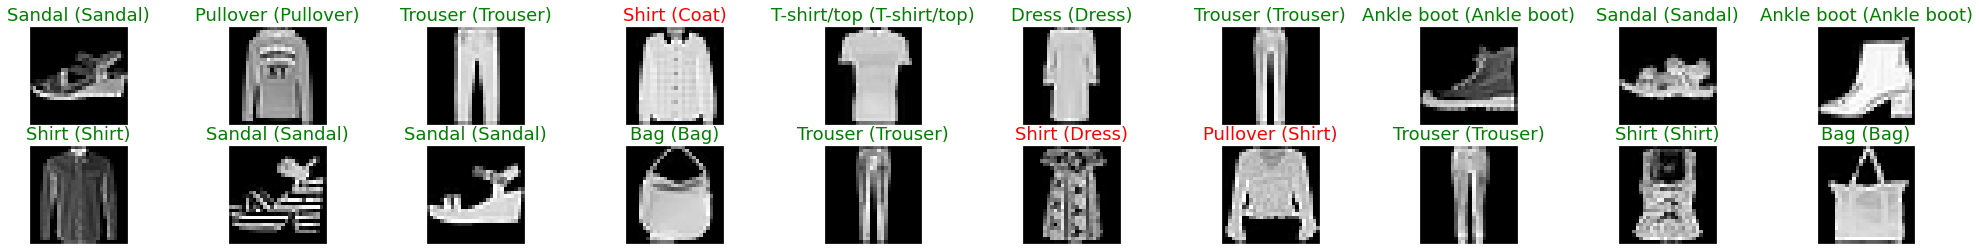

In [35]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

fig = plt.figure(figsize=(35, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## CNNs em Tensorflow

In [96]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.metrics import categorical_crossentropy
from keras.utils import to_categorical

In [55]:
X_train = train_data.data.numpy()
y_train = train_data.targets.numpy()
X_test = test_data.data.numpy()
y_test = test_data.targets.numpy()

In [84]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [105]:
batch_size = 64

model = Sequential()
model.add(Flatten())
model.add(keras.layers.Dense(units=25, input_shape = (None, 28,28), activation="relu"))
model.add(keras.layers.Dense(units=10, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.build((None, 28,28))
model.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 784)               0         
                                                                 
 dense_38 (Dense)            (None, 25)                19625     
                                                                 
 dense_39 (Dense)            (None, 10)                260       
                                                                 
Total params: 19,885
Trainable params: 19,885
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.fit(
    X_train,
    y_train,
    batch_size = batch_size,
    verbose=2,
    epochs=10)

Epoch 1/10
938/938 - 2s - loss: 3.0901 - accuracy: 0.1998 - 2s/epoch - 3ms/step
Epoch 2/10
938/938 - 1s - loss: 1.7946 - accuracy: 0.3155 - 1s/epoch - 1ms/step
Epoch 3/10
938/938 - 1s - loss: 1.5082 - accuracy: 0.3947 - 1s/epoch - 1ms/step
Epoch 4/10
938/938 - 1s - loss: 1.2520 - accuracy: 0.4992 - 1s/epoch - 1ms/step
Epoch 5/10
938/938 - 1s - loss: 1.1650 - accuracy: 0.5198 - 1s/epoch - 1ms/step
Epoch 6/10
938/938 - 1s - loss: 1.1063 - accuracy: 0.5422 - 1s/epoch - 2ms/step
Epoch 7/10
938/938 - 1s - loss: 1.0264 - accuracy: 0.5779 - 1s/epoch - 2ms/step
Epoch 8/10
938/938 - 2s - loss: 0.9789 - accuracy: 0.5893 - 2s/epoch - 2ms/step
Epoch 9/10
938/938 - 2s - loss: 0.9182 - accuracy: 0.6428 - 2s/epoch - 2ms/step
Epoch 10/10
938/938 - 1s - loss: 0.8296 - accuracy: 0.7008 - 1s/epoch - 1ms/step


In [107]:
predictions = model.predict(X_test)

313/313 [==============================] - 0s 926us/step


In [109]:
predictions = np.argmax(predictions, axis = 1)

In [110]:
print(accuracy_score(np_test_y, predictions))

0.7176


In [97]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides= (2,2)))
model.add(Conv2D(64, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides= (2,2)))
model.add(Flatten())
model.add(Dense(25, activation="relu")) 
model.add(Dense(10, activation="softmax")) 

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.fit(
    X_train,
    y_train,
    verbose=2,
    epochs=10,
)

Epoch 1/10
1875/1875 - 45s - loss: 1.0044 - accuracy: 0.6399 - 45s/epoch - 24ms/step
Epoch 2/10
1875/1875 - 43s - loss: 0.4474 - accuracy: 0.8321 - 43s/epoch - 23ms/step
Epoch 3/10
1875/1875 - 44s - loss: 0.3552 - accuracy: 0.8700 - 44s/epoch - 24ms/step
Epoch 4/10
1875/1875 - 41s - loss: 0.3219 - accuracy: 0.8809 - 41s/epoch - 22ms/step
Epoch 5/10
1875/1875 - 42s - loss: 0.2980 - accuracy: 0.8898 - 42s/epoch - 22ms/step
Epoch 6/10
1875/1875 - 43s - loss: 0.2838 - accuracy: 0.8942 - 43s/epoch - 23ms/step
Epoch 7/10
1875/1875 - 41s - loss: 0.2731 - accuracy: 0.8978 - 41s/epoch - 22ms/step
Epoch 8/10
1875/1875 - 41s - loss: 0.2606 - accuracy: 0.9022 - 41s/epoch - 22ms/step
Epoch 9/10
1875/1875 - 41s - loss: 0.2520 - accuracy: 0.9052 - 41s/epoch - 22ms/step
Epoch 10/10
1875/1875 - 42s - loss: 0.2445 - accuracy: 0.9082 - 42s/epoch - 22ms/step


In [104]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis = 1)
print(accuracy_score(np_test_y, predictions))

313/313 [==============================] - 2s 7ms/step
0.8816
